# Tuning Confidence Score of Flight Call Detections
_Ashley Huang, Carlene English_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
from suntime import Sun
from dateutil import tz
import os
if not os.path.exists('exports'):
    os.makedirs('exports')

In [202]:
taxon = 'leasan'

common_names = {
    'semplo': 'Semipalmated Plover', 
    'greyel': 'Greater Yellowlegs', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
    'baisan': 'Baird\'s Sandpiper', 
    'wilsni': 'Wilson\'s Snipe', 
    'leasan': 'Least Sandpiper'
}

## 1. Plot the distribution of confidence scores
The `reviewStutus` column of the exported CSV file can be either `Reviewed`, `Problem`, or `Unreviewed`. In this notebook, we will use _correct_ and _incorrect_ to describe `Reviewed` and `Problem` detections; the term _reviewed_ will denote both _correct_ and _incorrect_ detections.
We plot histograms of the confidence scores of `Reviewed`, 

reviewStatus
Unreviewed    1255
Reviewed        67
Problem         48
Name: count, dtype: int64

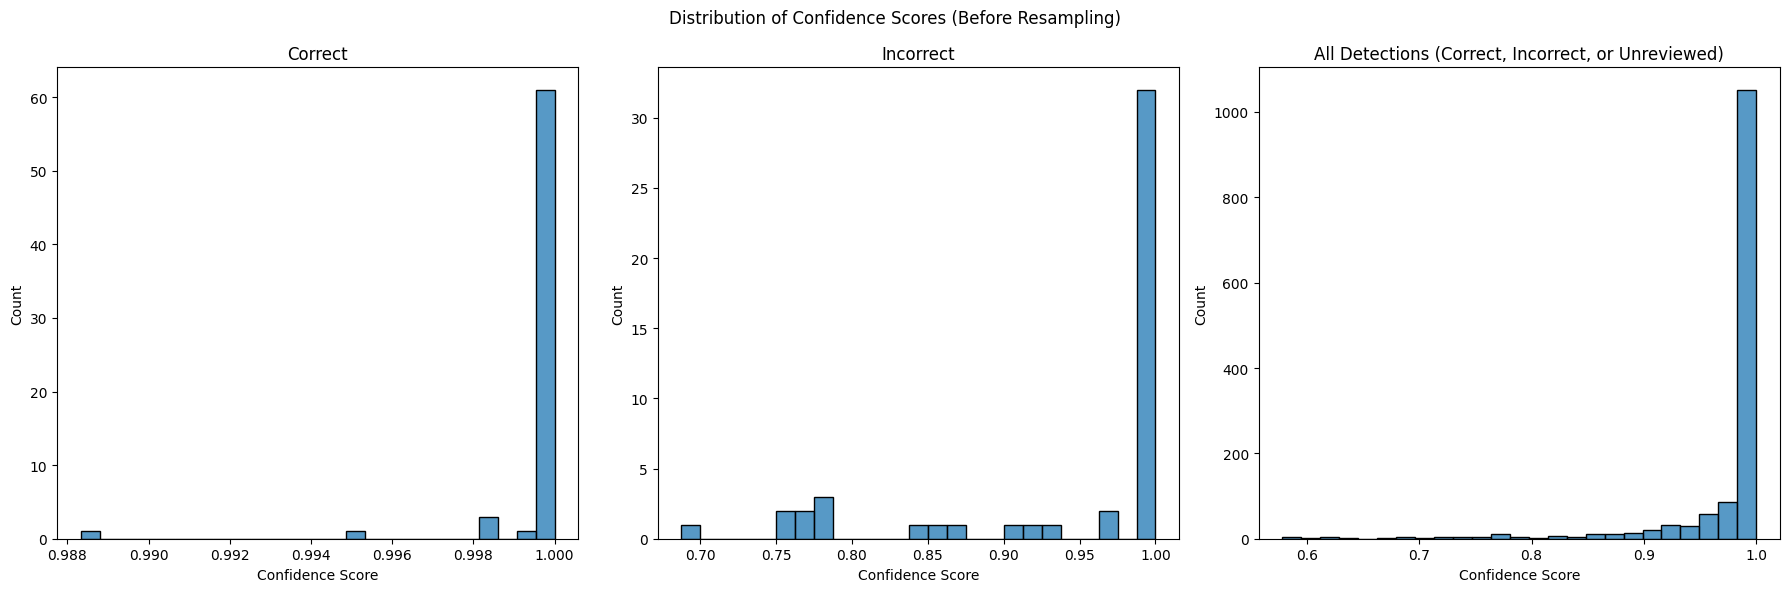

In [ ]:
if taxon == 'uplsan':
    df_flood = pd.read_csv(f'detections/uplsan_flood.csv')
    df_correct = pd.read_csv(f'detections/uplsan_correct.csv')
    df_incorrect = pd.read_csv(f'detections/uplsan_incorrect.csv')
    df = pd.concat([df_flood, df_correct, df_incorrect])
else:
    df = pd.read_csv(f'detections/{taxon}.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(df[df['reviewStatus'] == 'Reviewed']['confidenceScore'].values, bins=25, ax=axes[0])
sns.histplot(df[df['reviewStatus'] == 'Problem']['confidenceScore'].values, bins=25, ax=axes[1])
sns.histplot(df['confidenceScore'].values, bins=25, ax=axes[2])
axes[0].set_title('Correct')
axes[1].set_title('Incorrect')
axes[2].set_title('All Detections (Correct, Incorrect, or Unreviewed)')
axes[0].set_xlabel('Confidence Score')
axes[1].set_xlabel('Confidence Score')
axes[2].set_xlabel('Confidence Score')
plt.suptitle('Distribution of Confidence Scores (Before Resampling)')
plt.tight_layout()

df['reviewStatus'].value_counts()

FileNotFoundError: [Errno 2] No such file or directory: 'exportds/leasan_before_resampling.png'

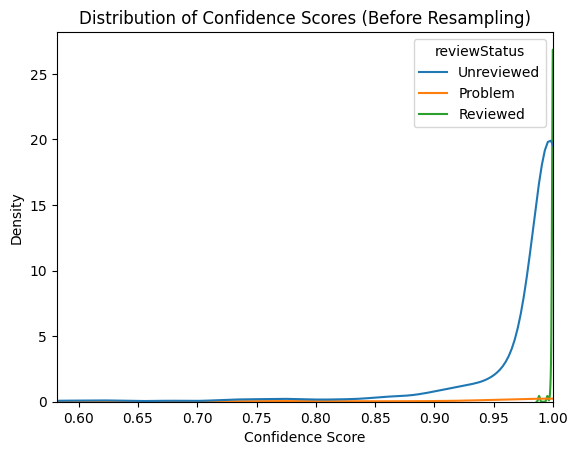

In [ ]:
sns.kdeplot(df, x='confidenceScore', hue='reviewStatus')
plt.title('Distribution of Confidence Scores (Before Resampling)')
plt.xlabel('Confidence Score')
plt.xlim(df['confidenceScore'].quantile(1e-3), 1)
plt.savefig(f'exports/{taxon}_before_resampling.png')

## 2. Filter Out Daytime Detections
First, we filter out unreviewed detections and assign 0/1 to incorrect/correct detections. Then, we filter out daytime flight calls. Timestamps are compared to the sunset/sunrise time of MPG ranch. Once we obtained coordinated of each site, timestamp should be compared to the sunset/sunrise time of the corresponding site.

In [205]:
# Filter out unreviewed detections
df['reviewStatusBinary'] = df['reviewStatus'].map({'Reviewed': 1, 'Problem': 0, 'Unreviewed': -1})
df_reviewed = df[df['reviewStatusBinary'] >= 0]

# Filter by sunset and sunrise time
time_format = '%Y-%m-%dT%H:%M:%S.%fZ'
lat, lon = 47.0559593, -116.3273099
sun = Sun(lat, lon)
def is_noctural(time_str, after_sunset=timedelta(minutes=0), before_sunrise=timedelta(minutes=0)):
    timestamp = datetime.strptime(time_str, time_format)
    timestamp = timestamp.replace(tzinfo=timezone.utc)
    sunrise = sun.get_local_sunrise_time(timestamp, tz.gettz('America/Denver'))
    sunset = sun.get_local_sunset_time(timestamp + timedelta(days=1), tz.gettz('America/Denver'))
    timestamp.astimezone(tz.gettz('American/Denver'))
    if timestamp.date() != sunset.date() or timestamp.date() != sunrise.date():
        print(sunrise, sunset, timestamp)
    if timestamp < sunrise - before_sunrise or timestamp > sunset + after_sunset:
        return True
    return False
total_detections = len(df_reviewed.index)
df_reviewed = df_reviewed[df_reviewed['timestamp'].apply(is_noctural)]
print('nocturnal detections:', total_detections)
print('durinal detections:', total_detections - len(df_reviewed.index))

nocturnal detections: 115
durinal detections: 42


## 3. Resample Reviewed Detections to Match the Distribution of All Detections

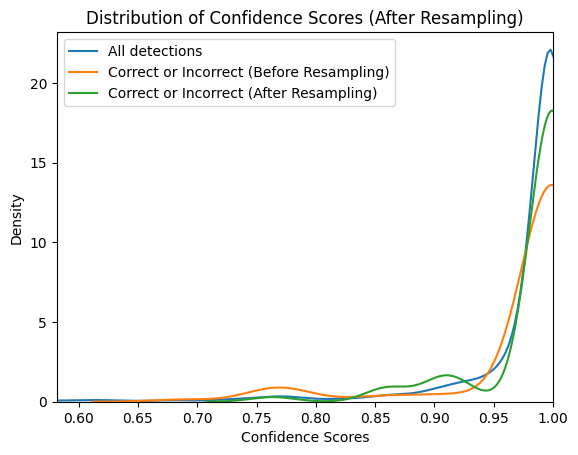

In [206]:
scores = df['confidenceScore']
scores_reviewed = df_reviewed['confidenceScore']
kde = gaussian_kde(scores)
kde_reviewed = gaussian_kde(scores_reviewed)
weights = kde.evaluate(scores_reviewed) / kde_reviewed.evaluate(scores_reviewed)
weights /= weights.sum()
indicies = np.random.choice(df_reviewed.index, size=len(df_reviewed), p=weights, replace=True)
df_resampled = df_reviewed.loc[indicies]

X = df_resampled['confidenceScore'].values.reshape(-1, 1) # X.shape = (N, 1)
y = df_resampled['reviewStatusBinary'].values # y.shape = (N)

sns.kdeplot(df['confidenceScore'], color='#1f77b4', label='All detections')
sns.kdeplot(df[df['reviewStatus'].isin(['Reviewed', 'Problem'])]['confidenceScore'].values, color='#ff7f0e', label='Correct or Incorrect (Before Resampling)')
sns.kdeplot(df_resampled['confidenceScore'], color='#2ca02c', label='Correct or Incorrect (After Resampling)')
plt.title('Distribution of Confidence Scores (After Resampling)')
plt.xlabel('Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-3), 1)
plt.legend()

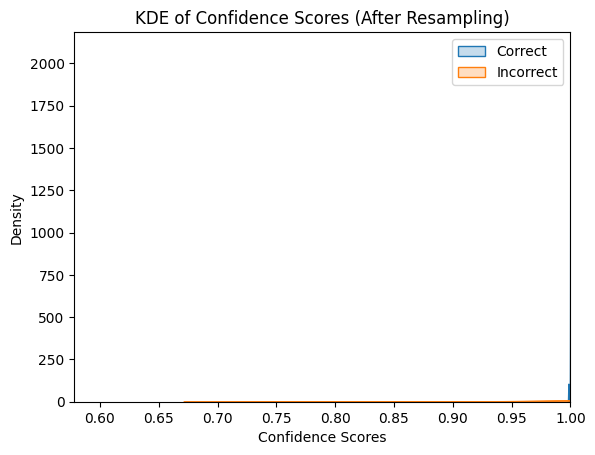

In [207]:
sns.kdeplot(data=df_resampled[df_resampled['reviewStatusBinary'] == 1], x='confidenceScore', label='Correct', fill=True)
sns.kdeplot(data=df_resampled[df_resampled['reviewStatusBinary'] == 0], x='confidenceScore', label='Incorrect', fill=True)
plt.title('KDE of Confidence Scores (After Resampling)')
plt.xlabel('Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.legend()
plt.savefig(f'exports/{taxon}_after_resampling.png')

## 5. Fit with Logistic Regression

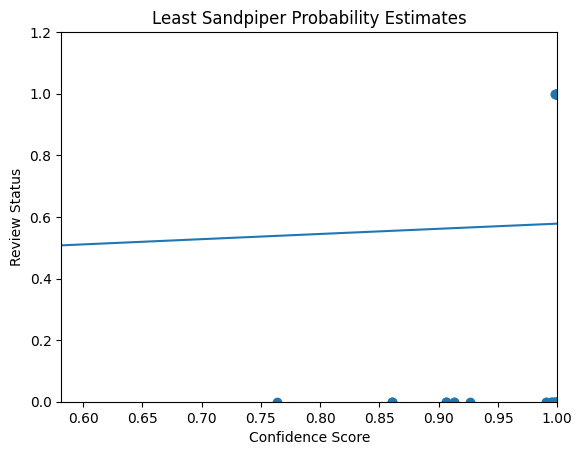

In [208]:
logr = LogisticRegression()
logr.fit(X, y)

plt.scatter(df_resampled['confidenceScore'], df_resampled['reviewStatusBinary'])
plt.ylim(0, 1.2)
plt.xlabel('Confidence Score')
plt.ylabel('Review Status')
plt.title(f'{common_names[taxon]} Probability Estimates')

x_range = np.linspace(0, 1, 100).reshape(-1, 1)
y_prob = logr.predict_proba(x_range)[:, 1]
plt.plot(x_range, y_prob)
plt.xlim(df['confidenceScore'].quantile(1e-3), 1)
plt.savefig(f'exports/{taxon}_probability_estimates.png')